# Projeto de Mineração de Dados

***João Condeço, m56970 - Engenharia Informática***

# Dataset

[90,000+ Cars Data From 1970 to 2024](https://www.kaggle.com/datasets/meruvulikith/90000-cars-data-from-1970-to-2024?resource=download)

# Introdução

# Preparação dos Dados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

df = pd.read_csv('used_cars_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97712 entries, 0 to 97711
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         97712 non-null  object 
 1   year          97712 non-null  int64  
 2   price         97712 non-null  int64  
 3   transmission  97712 non-null  object 
 4   mileage       97712 non-null  int64  
 5   fuelType      97712 non-null  object 
 6   tax           97712 non-null  int64  
 7   mpg           97712 non-null  float64
 8   engineSize    97712 non-null  float64
 9   Manufacturer  97712 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 7.5+ MB


In [26]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer
0,I10,2017,7495,Manual,11630,Petrol,145,60.1,1.0,hyundi
1,Polo,2017,10989,Manual,9200,Petrol,145,58.9,1.0,volkswagen
2,2 Series,2019,27990,Semi-Auto,1614,Diesel,145,49.6,2.0,BMW
3,Yeti Outdoor,2017,12495,Manual,30960,Diesel,150,62.8,2.0,skoda
4,Fiesta,2017,7999,Manual,19353,Petrol,125,54.3,1.2,ford


In [21]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,97712.000000,97712.000000,97712.000000,97712.000000,97712.000000,97712.000000
mean,2017.066502,16773.487555,23219.475499,120.142408,55.205623,1.664913
std,2.118661,9868.552222,21060.882301,63.357250,16.181659,0.558574
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7673.000000,125.000000,47.100000,1.200000
50%,2017.000000,14470.000000,17682.500000,145.000000,54.300000,1.600000
75%,2019.000000,20750.000000,32500.000000,145.000000,62.800000,2.000000
max,2024.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


### Filtrar os dados

In [30]:
columns_to_keep = ['year', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'Manufacturer', 'price']
df = df[columns_to_keep]


### Aplicar Label Encoding nas variáveis categóricas

In [ ]:
from sklearn.preprocessing import LabelEncoder

# initialize LabelEncoder
le = LabelEncoder()
label_mappings = {}

# apply Label Encoding to each categorical column
categorical_columns = ['transmission', 'fuelType', 'Manufacturer']
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])
    # save original mapping
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    
df.head()

,year,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer,price
0,2017,1,11630,4,145,60.1,1.0,3,7495
1,2017,1,9200,4,145,58.9,1.0,8,10989
2,2019,3,1614,0,145,49.6,2.0,1,27990
3,2017,1,30960,0,150,62.8,2.0,5,12495
4,2017,1,19353,4,125,54.3,1.2,2,7999


### Missing values

In [4]:
df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
Manufacturer    0
dtype: int64

### Distribuição de preços

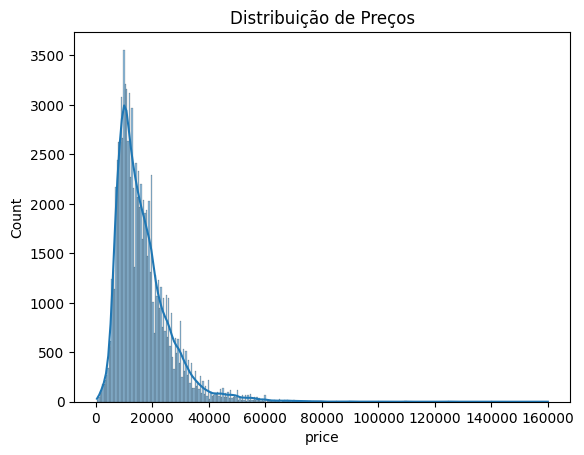

In [32]:
sns.histplot(df['price'], kde=True)
plt.title('Distribuição de Preços')
plt.show()

### Correlação entre variáveis

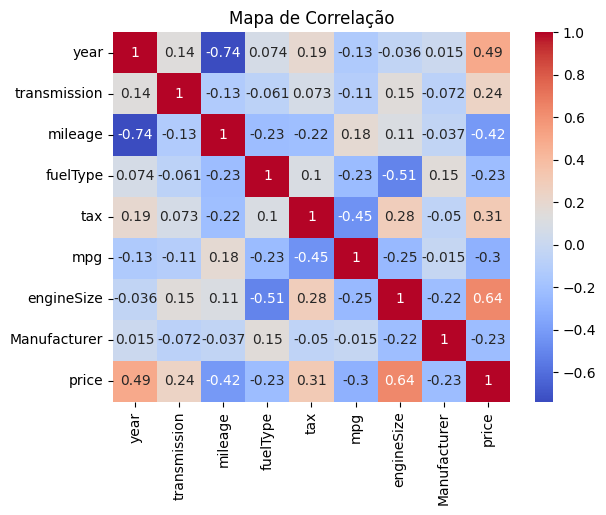

In [33]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Correlação')
plt.show()

### Análise das Correlações
1. Correlação com price (variável alvo):
- year (0.49): Existe uma correlação moderada positiva entre o ano de fabrico do veículo e o preço. Veículos mais novos tendem a ser mais caros.
- engineSize (0.64): Apresenta a correlação mais forte com o preço, o que indica que veículos com motores maiores tendem a ter preços mais elevados.
- tax (0.31): Correlação positiva moderada, sugerindo que carros com impostos mais altos estão geralmente associados a preços mais elevados.
- mileage (-0.42): Correlação negativa moderada, o que faz sentido, pois veículos com maior quilometragem tendem a ter preços mais baixos.
- mpg (-0.3): Correlação negativa fraca, sugerindo que veículos mais eficientes em consumo de combustível (maiores milhas por galão) têm preços ligeiramente mais baixos.

2. Outras correlações relevantes entre variáveis independentes:
- year e mileage (-0.74): Forte correlação negativa. Veículos mais recentes tendem a ter menor quilometragem.
- engineSize e fuelType (-0.51): Relacionamento que pode refletir que motores maiores são geralmente associados a certos tipos de combustível (provavelmente diesel).

### VIF (Variance Inflation Factor)

Variáveis com VIF > 10 indicam alta multicolinearidade e podem ser removidas.

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant  # Import from statsmodels directly

X = df[['year', 'mileage', 'tax', 'mpg', 'engineSize']]
X = add_constant(X)  # Add constant for the calculation

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,const,2.017469e+06
1,year,2.223320e+00
2,mileage,2.327246e+00
3,tax,1.356204e+00
4,mpg,1.305498e+00
5,engineSize,1.156594e+00


Não há necessidade de remover nenhuma variável neste momento. Todas as variáveis têm valores aceitáveis de VIF e podem ser mantidas no modelo.

# Algoritmos e Modelos

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = df[['year', 'mileage', 'tax', 'mpg', 'engineSize']]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [38]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Métricas do Modelo de Regressão Linear:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Métricas do Modelo de Regressão Linear:
Mean Squared Error (MSE): 28995014.49
Root Mean Squared Error (RMSE): 5384.70
R² Score: 0.70


O modelo de Regressão Linear conseguiu capturar bem a relação entre as variáveis preditoras e o preço, mas há espaço para melhorias:

- O RMSE mostra que há uma margem de erro que pode ser reduzida com modelos mais complexos.
- O R² sugere que os dados têm um padrão explicável, mas possivelmente existem relações não lineares ou interações que a Regressão Linear não conseguiu capturar.

## Random Forest Regressor

In [39]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Metrics:")
print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")

Random Forest Metrics:
MSE: 12321662.44
RMSE: 3510.22
R² Score: 0.87


#### Ajuste dos hiperparâmetros

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Melhores Parâmetros:", grid_search.best_params_)

Melhores Parâmetros: {'max_depth': 20, 'n_estimators': 200}


In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

best_rf_model = RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)
best_rf_model.fit(X_train, y_train)

y_pred_best_rf = best_rf_model.predict(X_test)

mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("Métricas do Modelo Random Forest Otimizado:")
print(f"MSE: {mse_best_rf:.2f}")
print(f"RMSE: {rmse_best_rf:.2f}")
print(f"R² Score: {r2_best_rf:.2f}")


Métricas do Modelo Random Forest Otimizado:
MSE: 11534250.95
RMSE: 3396.21
R² Score: 0.88


### Importância das variáveis

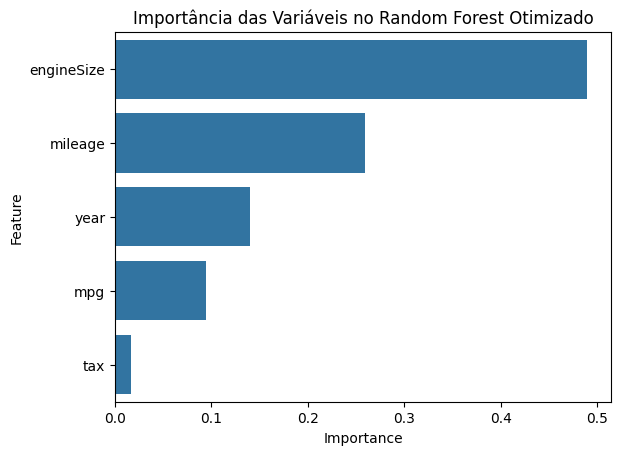

In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Importância das Variáveis no Random Forest Otimizado")
plt.show()


### Teste com feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

numeric_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']

scaler = StandardScaler()

df_scaled = df.copy()
df_scaled[numeric_features] = scaler.fit_transform(df_scaled[numeric_features])

df_scaled.head()

,year,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer,price
0,-0.031389,1,-0.550287,4,0.392342,0.302466,-1.190382,3,7495
1,-0.031389,1,-0.665668,4,0.392342,0.228308,-1.190382,8,10989
2,0.912609,3,-1.025863,0,0.392342,-0.346420,0.599900,1,27990
3,-0.031389,1,0.367533,0,0.471260,0.469322,0.599900,5,12495
4,-0.031389,1,-0.183587,4,0.076670,-0.055966,-0.832326,2,7999


In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_scaled = df_scaled[['year', 'mileage', 'tax', 'mpg', 'engineSize']]
y = df['price']  
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

best_rf_model_scaled = RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)
best_rf_model_scaled.fit(X_train_scaled, y_train)

y_pred_scaled = best_rf_model_scaled.predict(X_test_scaled)

mse_scaled = mean_squared_error(y_test, y_pred_scaled)
rmse_scaled = np.sqrt(mse_scaled)
r2_scaled = r2_score(y_test, y_pred_scaled)

print("Métricas do Random Forest com scaled data:")
print(f"MSE: {mse_scaled:.2f}")
print(f"RMSE: {rmse_scaled:.2f}")
print(f"R² Score: {r2_scaled:.2f}")


Métricas do Random Forest com Dados Escalados:
MSE: 11532067.99
RMSE: 3395.89
R² Score: 0.88


## Implementação do Gradient Boosting Regressor

In [51]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

gbr_model = GradientBoostingRegressor(n_estimators=200, max_depth=20, learning_rate=0.1, random_state=42)
gbr_model.fit(X_train_scaled, y_train)

y_pred_gbr = gbr_model.predict(X_test_scaled)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("Métricas do Gradient Boosting Regressor:")
print(f"MSE: {mse_gbr:.2f}")
print(f"RMSE: {rmse_gbr:.2f}")
print(f"R² Score: {r2_gbr:.2f}")


Métricas do Gradient Boosting Regressor:
MSE: 16094851.31
RMSE: 4011.84
R² Score: 0.83


## Remoção de outliers no Random Forest

In [53]:
def remove_outliers(df, columns):
    df_cleaned = df.copy()
    for col in columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    return df_cleaned

numeric_cols = ['price', 'mileage', 'engineSize', 'tax', 'mpg']

df_cleaned = remove_outliers(df_scaled, numeric_cols)

print(f"Registros antes da remoção de outliers: {df_scaled.shape[0]}")
print(f"Registros depois da remoção de outliers: {df_cleaned.shape[0]}")


Registros antes da remoção de outliers: 97712
Registros depois da remoção de outliers: 63436


In [54]:
X_cleaned = df_cleaned[['year', 'mileage', 'tax', 'mpg', 'engineSize']]
y_cleaned = df_cleaned['price']
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42
)

best_rf_model_cleaned = RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)
best_rf_model_cleaned.fit(X_train_cleaned, y_train_cleaned)

y_pred_cleaned = best_rf_model_cleaned.predict(X_test_cleaned)

mse_cleaned = mean_squared_error(y_test_cleaned, y_pred_cleaned)
rmse_cleaned = np.sqrt(mse_cleaned)
r2_cleaned = r2_score(y_test_cleaned, y_pred_cleaned)

print("Métricas do Random Forest Após Remoção de Outliers:")
print(f"MSE: {mse_cleaned:.2f}")
print(f"RMSE: {rmse_cleaned:.2f}")
print(f"R² Score: {r2_cleaned:.2f}")


Métricas do Random Forest Após Remoção de Outliers:
MSE: 8082898.45
RMSE: 2843.04
R² Score: 0.84


## Feature Engineering

In [55]:
df_cleaned['year_mileage_ratio'] = df_cleaned['year'] / (df_cleaned['mileage'] + 1)
df_cleaned['engine_mpg_interaction'] = df_cleaned['engineSize'] * df_cleaned['mpg']
df_cleaned['log_price'] = np.log1p(df_cleaned['price'])
df_cleaned['log_mileage'] = np.log1p(df_cleaned['mileage'])


/Users/joao/Documents/Coding/Python/data_mining/data_mining_project/venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

gbr_model = GradientBoostingRegressor(
    n_estimators=200,         
    max_depth=20,             
    min_samples_split=2,      
    min_samples_leaf=1,       
    learning_rate=0.1,        
    subsample=1.0,            
    random_state=42           
)

gbr_model.fit(X_train_cleaned, y_train_cleaned)

y_pred_gbr = gbr_model.predict(X_test_cleaned)

mse_gbr = mean_squared_error(y_test_cleaned, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
r2_gbr = r2_score(y_test_cleaned, y_pred_gbr)

print("Métricas do Gradient Boosting com Hiperparâmetros do Random Forest:")
print(f"MSE: {mse_gbr:.2f}")
print(f"RMSE: {rmse_gbr:.2f}")
print(f"R² Score: {r2_gbr:.2f}")


Métricas do Gradient Boosting com Hiperparâmetros do Random Forest:
MSE: 11094085.20
RMSE: 3330.78
R² Score: 0.78
